## Loading and preparing JSON data

We load jsons and save for each classified window. We'll save a big file with subject name, frame, confidence and
joint id; And later we'll add subject class and frame class. Where subject class is overall normal or abnormal, 
and frame class is tagged as if used for study (GM).

In [1]:
import json
import os
import pandas as pd


data = []
data_folder = 'D:/babybrain/confidences/'
data_files = sorted(os.listdir(data_folder))
for a_file in data_files:
    with open(data_folder + a_file) as json_file:
        single_data = json.load(json_file)
        my_frames = single_data['processed_frames']
        my_confidences = single_data['confidences']
        for frame_value, confidence_value in zip(my_frames, my_confidences):
            for index, a_confidence in enumerate(confidence_value):
                data.append([a_file[:-5], frame_value, a_confidence, index])

# create a DataFrame
columns = ['subject', 'frame', 'confidence', 'joint_id'] 
df = pd.DataFrame(data, columns=columns)

# save it as csv
df.to_csv('D:/babybrain/confidences.csv')

## Loading label data

We load the excel files with specialist classification, we'll add to prior data two 
columns containing subject class (1=normal, 0=abnormal) and frame class (1 is used as
General Movement and 0 if its not used as subject classification)

In [2]:
import pandas as pd


# a small function to check if a frame time is inside a tag stamp
def in_window(frame_sec, time_start, time_end, fps=240):
    return time_start.second + 60*time_start.minute <= frame_sec/fps <= time_end.second + 60*time_end.minute


# first we import from label files
label_path = 'D:/babybrain/SubjectTags.xlsx'
labels = pd.read_excel(label_path, engine='xlrd')

names = labels['Sujeto']
tag = labels['Normal']
# times are in date.time format
start = labels['T0']
end = labels['T1']

# now we import the processed data to add the columns
input_path = 'D:/babybrain/confidences.csv'
inputs = pd.read_csv(input_path)

# for each value in inputs we find the subject and check if frame inside a classification
input_names = inputs['subject']
frames = inputs['frame']
is_gm = []
is_normal = []
for index, an_input in enumerate(input_names):
    # search for subject index in the label data and then get all his intervals
    interval_indexes = [i for i, label in names.iteritems() if an_input == int(label)]
    # for each interval we check frame time is inside a label window
    if any([in_window(frames[index], start[subindex], end[subindex]) for subindex in interval_indexes]):
        is_gm.append(1)
        # we can append any of the intervals tag as normal or abnormal, its the same for all
        is_normal.append(int(tag[interval_indexes[0]]))
    else:
        is_gm.append(0)
        is_normal.append(-1)
    
# save new columns into Data Frame
inputs['is_gm'] = is_gm
inputs['is_normal'] = is_normal
inputs.to_csv(input_path)

## Using new labels and data exploration
We make an average value of joint confidence per class to check if at clear eye we
can tell a difference in values, even if we can't we can use effectively a random
forest classifier.

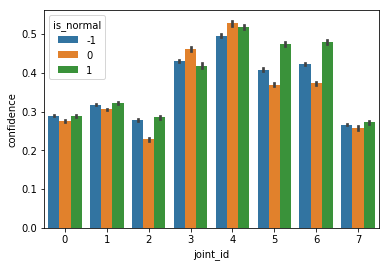

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get the data frame
input_path = 'D:/babybrain/confidences.csv'
data = pd.read_csv(input_path)

# create a simple graph with seaborn
graph = sns.barplot(x='joint_id', y='confidence', hue='is_normal', data=data)
plt.show()

## Training Random Forest Classifier
Now we use data to train a random forest classifier for either GM or normal.


abnormal ratio of data is 0.4930519814719506
Recall Baseline: 1.0 Test: 0.78 Train: 0.98
Precision Baseline: 0.51 Test: 0.84 Train: 1.0
Roc Baseline: 0.5 Test: 0.88 Train: 1.0


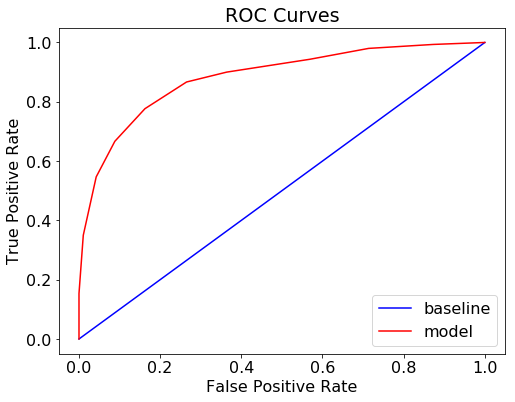

In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from qol import evaluate_model


# get the data frame
input_path = 'D:/babybrain/confidences.csv'
data = pd.read_csv(input_path)

# prepare the data to fit in the model, we need to compress the confidences into a vector
classifying = 'is_normal'
label = data[classifying].tolist()
confidences = data['confidence'].tolist()
joint_id = data['joint_id'].tolist()

X = []
y = []
step = max(joint_id) + 1
for index in range(0, len(label), step+1):
    # this is how we mark trash data
    if label[index] < 0 or np.any(np.isnan(confidences[index:index+step])):
        continue
    X.append(confidences[index:index+step])
    y.append(label[index])
print("abnormal ratio of data is {}".format(1 - (sum(y)/len(y))))

# split data
train, test, train_labels, test_labels = train_test_split(X, y, test_size=0.3)
# create the model with many many trees
model = RandomForestClassifier(n_estimators=10, bootstrap=True, max_features='sqrt')

# fit on training data
model.fit(train, train_labels)

# calculate ROC for model
train_prediction = model.predict(train)
train_prob = model.predict_proba(train)[:, 1]

prediction = model.predict(test)
prob = model.predict_proba(test)[:, 1]

evaluate_model(prediction, prob, train_prediction, train_prob, train_labels, test_labels,
               output='model_roc.png')

## Checking the Classifier accuracy

We can use sklearn's internal library to check a ROC curve for accuracy.

In [ ]:
# get the data frame
input_path = 'D:/babybrain/confidences.csv'
data = pd.read_csv(input_path)
print(data)
